In [159]:
import numpy as np
import pandas as pd
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from datetime import datetime,date
import datetime as dt
from collections import Counter
from matplotlib.ticker import FuncFormatter
import tensorflow as tf
import time

import seaborn as sns
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import roc_auc_score
from tensorflow import keras
from sklearn.calibration import calibration_curve

# Needed for decision tree visualization
import pydotplus
from IPython.display import Image


In [160]:
#load the data

file_path = Path('./Resources/serviced_dataframe_w_return.csv')
df = pd.read_csv('serviced_dataframe_w_return.csv')[:-2]


In [161]:
df.shape

(1040752, 37)

In [162]:
list(df)

['id',
 'application_type',
 'desc',
 'loan_amnt',
 'funded_amnt',
 'term',
 'int_rate',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'purpose',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'open_acc',
 'pub_rec',
 'fico_range_high',
 'fico_range_low',
 'revol_bal',
 'revol_util',
 'total_pymnt',
 'recoveries',
 'last_pymnt_d',
 'year_months',
 'has_desc',
 'credit_hist',
 'loan_length',
 'term_num',
 'ret_low',
 'ret_high',
 'good',
 'emp_length_num']

In [163]:
# Identify the type of each of these column
float_cols = ['loan_amnt', 'funded_amnt','annual_inc',
                     'dti', 'revol_bal', 'delinq_2yrs', 'open_acc', 'pub_rec',
                                'fico_range_high', 'fico_range_low', 'total_pymnt', 'recoveries']
cat_cols = ['term', 'grade', 'sub_grade', 'desc', 'emp_length', 'home_ownership',
                    'verification_status', 'loan_status', 'purpose','application_type']
perc_cols = ['int_rate', 'revol_util','ret_low','ret_high']
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'year_months']

In [164]:
#define the loan status

#d =  {'Fully Paid':0, 'Charged Off':1, 'Default':1}

#df['loan_status'] = df['loan_status']. map(d)

In [165]:
#new FICO average

df['fico_avg'] = (df.fico_range_high + df.fico_range_low)/2

In [166]:
columns = [
 'application_type',
 'loan_amnt',
 'funded_amnt',
 'int_rate',
 'grade',
 'sub_grade',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'purpose',
 'dti',
 'delinq_2yrs',
 'open_acc',
 'pub_rec',
 'fico_avg',
 'fico_range_high',
 'fico_range_low',
 'revol_bal',
 'revol_util',
 'total_pymnt',
 'recoveries',
 'last_pymnt_d',
 'has_desc',
 'credit_hist',
 'loan_length',
 'term',
 'ret_low',
 'ret_high',
 'good',
 'emp_length_num'
]

target = ["good"]



In [167]:
df = df.loc[:, columns].copy()

In [168]:
# Create our features
X = df.copy()
X.drop('good', axis=1, inplace=True)

# Create our target
y = df['good']


In [169]:
to_drop = ['recoveries', 'total_pymnt', 'dti','last_pymnt_d',
         'revol_util', 'open_acc', 'pub_rec', 'revol_bal',
         'revol_util', 'delinq_2yrs','loan_length','fico_range_high','fico_range_low','ret_low','ret_high']

X.drop(to_drop, axis=1, inplace=True)


In [170]:
app =  {'Individual':0, 'Joint App':1}

X['application_type'] = X['application_type']. map(app)

In [171]:
grade =  {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7}

X['grade'] = X['grade']. map(grade)

In [172]:
t =  {' 36 months':0, ' 60 months':1}

X['term'] = X['term']. map(t)

In [173]:
v =  {'Not Verified':0, 'Source Verified':1, 'Verified':2}

X['verification_status'] = X['verification_status']. map(v)

In [174]:
d =  {False:0, True:1}

X['has_desc'] = X['has_desc']. map(d)

In [175]:
sub_grades = sorted(df.sub_grade.unique())
sub_grades_dict = {x:sub_grades.index(x)+1 for x in sub_grades} 
sub_grades_dict_reverse = {v:k for k,v in sub_grades_dict.items()} 

X['sub_grade'] = X['sub_grade']. map(sub_grades_dict)


In [176]:
X.sample(3).T

,352530,1013786,56699
application_type,0,1,0
loan_amnt,9950,17000,6500
funded_amnt,9950,17000,6500
int_rate,0.0999,0.1274,0.1299
grade,2,3,3
sub_grade,8,11,11
home_ownership,MORTGAGE,MORTGAGE,OWN
annual_inc,43361,46166,25707
verification_status,0,0,1
purpose,home_improvement,debt_consolidation,credit_card


In [177]:
cat_col = ['home_ownership','purpose']

X = pd.get_dummies(X, columns=cat_col)

In [178]:
X.describe()

,application_type,loan_amnt,funded_amnt,int_rate,grade,sub_grade,annual_inc,verification_status,fico_avg,has_desc,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
count,1.040752e+06,1.040752e+06,1.040752e+06,1.040752e+06,1.040752e+06,1.040752e+06,1.040752e+06,1.040752e+06,1.040752e+06,1.040752e+06,...,1.040752e+06,1.040752e+06,1.040752e+06,1.040752e+06,1.040752e+06,1.040752e+06,1.040752e+06,1.040752e+06,1.040752e+06,1.040752e+06
mean,7.756891e-03,1.472380e+04,1.472378e+04,1.294675e-01,2.753028e+00,1.171417e+01,7.711343e+04,1.010963e+00,6.959455e+02,1.473069e-02,...,6.354252e-02,3.820315e-03,1.986544e-02,1.082102e-02,6.519324e-03,5.376497e-02,6.043707e-04,9.622850e-03,6.310821e-03,1.345181e-05
std,8.773100e-02,8.685624e+03,8.685624e+03,4.576142e-02,1.283666e+00,6.382068e+00,7.162064e+04,7.552677e-01,3.048848e+01,1.204729e-01,...,2.439363e-01,6.169055e-02,1.395379e-01,1.034598e-01,8.047875e-02,2.255534e-01,2.457653e-02,9.762305e-02,7.918965e-02,3.667648e-03
min,0.000000e+00,1.000000e+03,1.000000e+03,5.320000e-02,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,6.620000e+02,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,8.000000e+03,8.000000e+03,9.170000e-02,2.000000e+00,7.000000e+00,4.600000e+04,0.000000e+00,6.720000e+02,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,1.270000e+04,1.270000e+04,1.269000e-01,3.000000e+00,1.100000e+01,6.500000e+04,1.000000e+00,6.870000e+02,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,2.000000e+04,2.000000e+04,1.561000e-01,4.000000e+00,1.600000e+01,9.200000e+04,2.000000e+00,7.120000e+02,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.000000e+00,4.000000e+04,4.000000e+04,3.099000e-01,7.000000e+00,3.500000e+01,9.573072e+06,2.000000e+00,8.475000e+02,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [179]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)



In [180]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(780564, 31)
(260188, 31)
(780564,)
(260188,)


In [181]:
# Creating StandardScaler instance
scaler = StandardScaler()


In [182]:
# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)


In [183]:

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)



## RANDOM FOREST CLASSIFIER

In [184]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=34)



In [186]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)


In [187]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)


In [188]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

cm_df

,Predicted 0,Predicted 1
Actual 0,3944,45956
Actual 1,4340,205948


In [189]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,3944,45956
Actual 1,4340,205948


Accuracy Score : 0.8066936215351976
Classification Report
              precision    recall  f1-score   support

           0       0.48      0.08      0.14     49900
           1       0.82      0.98      0.89    210288

    accuracy                           0.81    260188
   macro avg       0.65      0.53      0.51    260188
weighted avg       0.75      0.81      0.75    260188



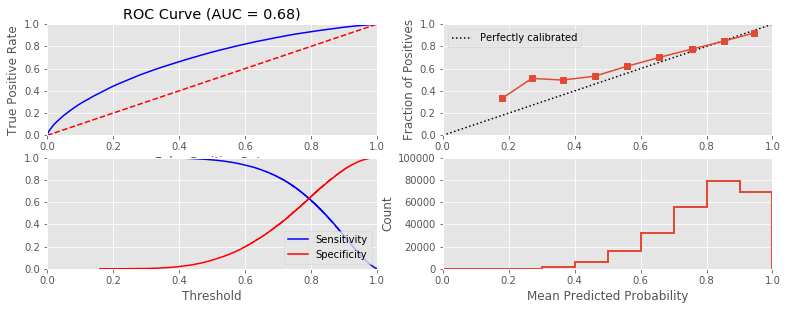

In [190]:
# get roc/auc info
Y_score = rf_model.predict_proba(X_test_scaled)[:,1]
Y_score_train = rf_model.predict_proba(X_train_scaled)[:,1]

fpr = dict()
tpr = dict()
thresholds = dict()
#fpr, tpr, _ = roc_curve(y_test, Y_score)
fpr, tpr, thresholds = roc_curve(y_test, Y_score)

roc_auc = dict()
roc_auc = auc(fpr, tpr)

# make the plot
# plt.figure(figsize=(10,10))
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim([-0.05, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.grid(True)
# plt.plot(fpr, tpr, label='AUC = {0}'.format(roc_auc))        
# plt.legend(loc="lower right", shadow=True, fancybox =True) 



plt.figure(figsize = (13, 4.5))
plt.subplot(2, 2, 1)

plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, Y_score))
plt.plot(fpr, tpr, 'b')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1]); plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.subplot(2, 2, 3)

plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
plt.legend(loc = 'lower right')
plt.xlim([0,1]); plt.ylim([0,1])
plt.xlabel('Threshold')

plt.subplot(2, 2, 2)

fp_0, mpv_0 = calibration_curve(y_test, Y_score, n_bins = 10)
plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
plt.plot(mpv_0, fp_0, 's-')
plt.ylabel('Fraction of Positives')
plt.xlim([0,1]); plt.ylim([0,1])
plt.legend(loc ='upper left')

plt.subplot(2, 2, 4)
plt.hist(Y_score, range=(0, 1), bins=10, histtype="step", lw=2)
plt.xlim([0,1]); plt.ylim([0,100000])
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Count')

plt.show()

In [229]:
def normalize_arrays(fit_arr, *arrs):
    scaler = StandardScaler()
    fit_arr = scaler.fit_transform(fit_arr)
    out=[]
    for arr in arrs:
        out.append(scaler.transform(arr))
    return [fit_arr]+out


In [230]:
def predict_probs(X_train, X_test, y_train, y_test,
                   model_name,
                   select_top=[0.05, 0.1, 0.2],
                   show_plot=True
                   ):

    # 1. Split 5% validation, Normalize
    X_train, X_val, y_train, Y_val = train_test_split(X_train, y_train, test_size=0.05)
    X_train, X_val, X_test = normalize_arrays(X_train, X_val, X_test)
   

    # 2. train model
    model = RandomForestClassifier(n_estimators=500, random_state=34)
    model = model.fit(X_train, y_train)

   

    # 3. predict Y_train_hat, Y_test_hat

    y_train_hat = model.predict_proba(X_train)[:,1]
    y_test_hat = model.predict_proba(X_test)[:,1]

    # 4. Produce metrics
    AUC_train = roc_auc_score(y_train, y_train_hat)
    AUC_test = roc_auc_score(y_test, y_test_hat)
    fp_test, tp_test, thresholds = roc_curve(y_test, y_test_hat)

    support = np.nanmean(y_test)
    indices = np.searchsorted(thresholds[::-1], np.quantile(y_test_hat, 1-np.array(select_top)))
    precision = 1/(1 + (fp_test[-indices]/tp_test[-indices])*(1/support-1))
    precision = {k:v for k,v in zip(select_top, precision)}
    precision.update({1:support})

    # 5. Optional: plot roc, precision graph
    if show_plot:
        plot_roc(y_train_hat, y_test_hat, y_train, y_test, model_name)
    
    print(f'{AUC_train:.5f} {AUC_test:.5f} \n{precision}')
    
    # include Y_test in the output for verification purposes (Y_test<-->Y_test_hat)
    return y_test, y_test_hat, AUC_train, AUC_test, precision

In [231]:
def plot_roc(y_train_hat, y_test_hat, y_train, y_test, model_name):

    #AUC_train = roc_auc_score(y_train, y_train_hat)
    AUC_test = roc_auc_score(y_test, y_test_hat)

    #fp_train, tp_train, _ = roc_curve(y_train, y_train_hat)
    fp_test, tp_test, thresholds = roc_curve(y_test, y_test_hat)

    precision = 1/(1+ (1/np.mean(y_test)-1)*(fp_test/tp_test))
    thresholds[0]=1  #sklearn may produce arbitrary first threshold > 1

    ref_thresholds = np.linspace(min(thresholds), max(thresholds),1000)
    selected = [np.nanmean(y_test_hat>p) for p in ref_thresholds]

    _,axes = plt.subplots(1, 2, figsize=(14, 6))
    ax0,ax1=axes[0],axes[1]

   # ax0.plot(fp_train, tp_train, label=f'Train. AUC={AUC_train:.4f}')
    ax0.plot(fp_test, tp_test, label=f'Test. AUC={AUC_test:.4f}')
    ax0.plot((0,1),(0,1), color='grey')
    ax0.plot((np.mean(y_train)), (np.mean(y_train)), color='grey', marker='o', label='random')
    ax0.set_xlabel('false positive rate')
    ax0.set_ylabel('recall')
    ax0.set_title(f'ROC: {model_name}')
    ax0.legend(loc='lower right')
    ax0.grid(True)

    ax1.plot(thresholds, precision, label=f'precision')
    ax1.plot(ref_thresholds, selected, label=f'selected %')
    ax1.set_xlabel('cutoff thresholds')
    ax1.set_title(f'Precision and selected %')
    ax1.legend(loc='lower right')
    ax1.invert_xaxis()
    ax1.grid(True)

    plt.show()

In [237]:
# a general report dataframe structure:
df_template = pd.DataFrame(columns=['model',
                                  'run',
                                  'n_loans',
                                  'AUC_test',
                                  'prec_5',
                                  'prec_10',
                                  'prec_20',
                                  'support',
                                  'ratio_5',
                                  'ratio_10',
                                  'ratio_20',

                                  ])
df_template

,model,run,n_loans,AUC_test,prec_5,prec_10,prec_20,support,ratio_5,ratio_10,ratio_20


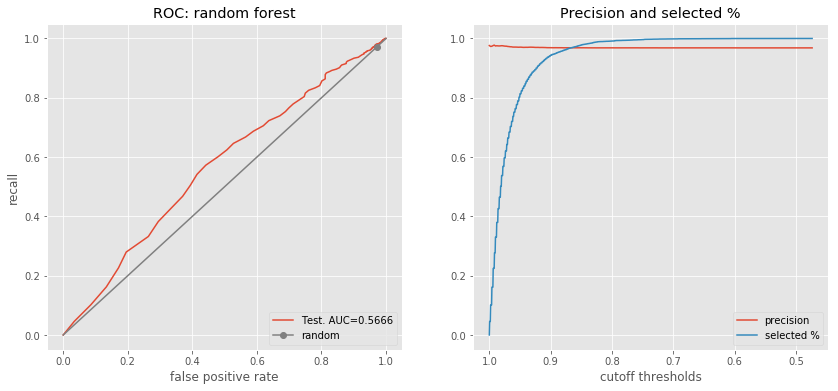

1.00000 0.56664 
{0.05: 0.9735951252538929, 0.1: 0.9735951252538929, 0.2: 0.9775413711583923, 1: 0.9681292294258895}
['A1']


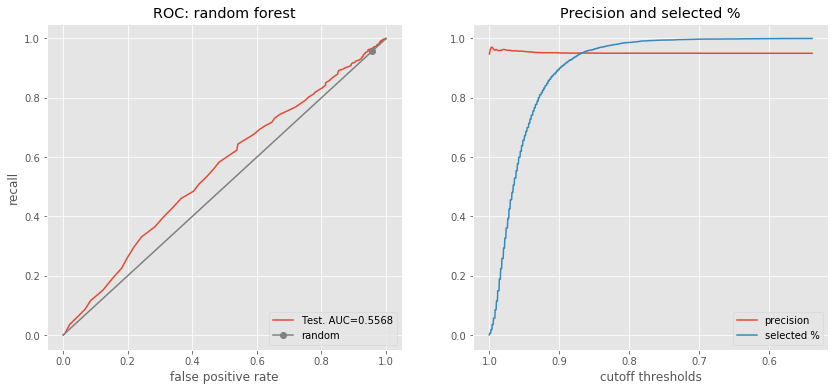

1.00000 0.55681 
{0.05: 0.9603448275862068, 0.1: 0.958783120706575, 0.2: 0.9613636363636364, 1: 0.9498827667057445}
['A2']


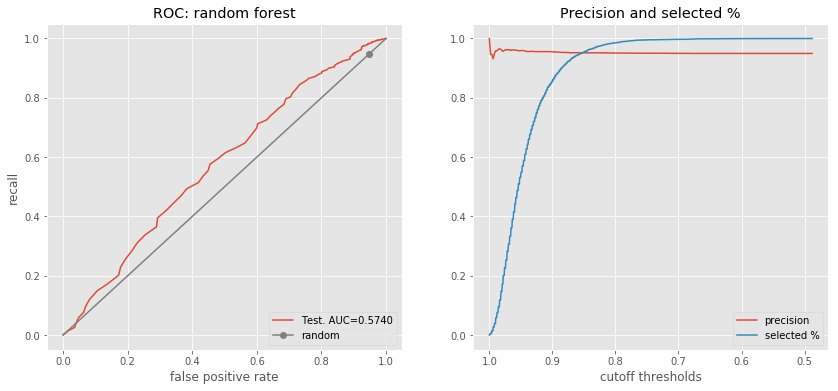

1.00000 0.57396 
{0.05: 0.9578313253012049, 0.1: 0.9637305699481865, 0.2: 0.9603227975790181, 1: 0.9494672754946728}
['A3']


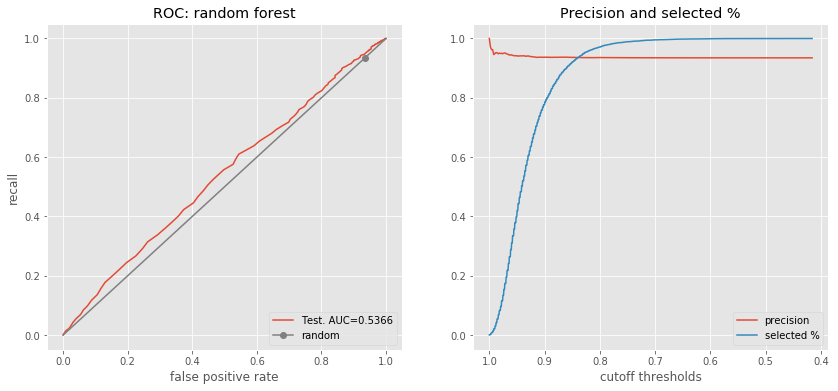

1.00000 0.53656 
{0.05: 0.9482496194824962, 0.1: 0.9485179407176287, 0.2: 0.9467301862278042, 1: 0.9345989360592469}
['A4']


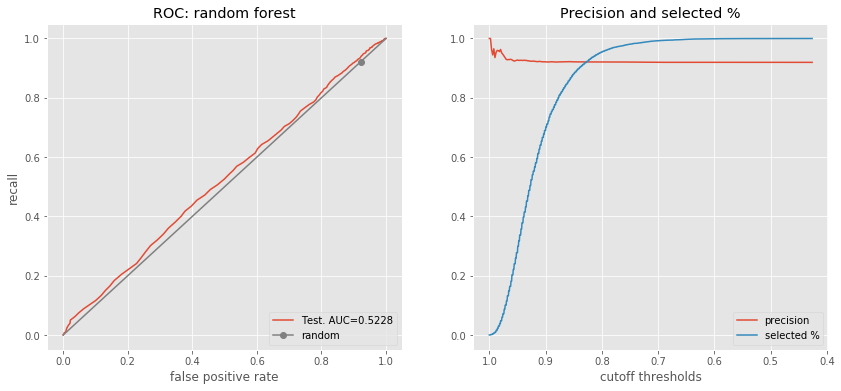

1.00000 0.52284 
{0.05: 0.9468325791855203, 0.1: 0.9295278365045808, 0.2: 0.9258443465491925, 1: 0.9194358891230345}
['A5']


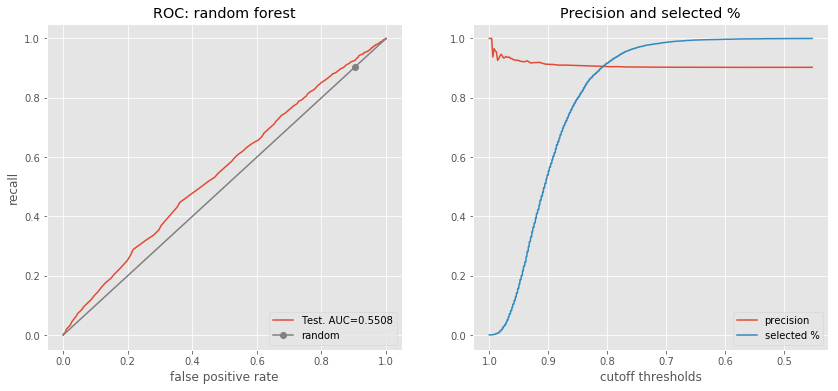

1.00000 0.55079 
{0.05: 0.936144578313253, 0.1: 0.9273885350318471, 0.2: 0.9221045439016058, 1: 0.9026574876008587}
['B1']


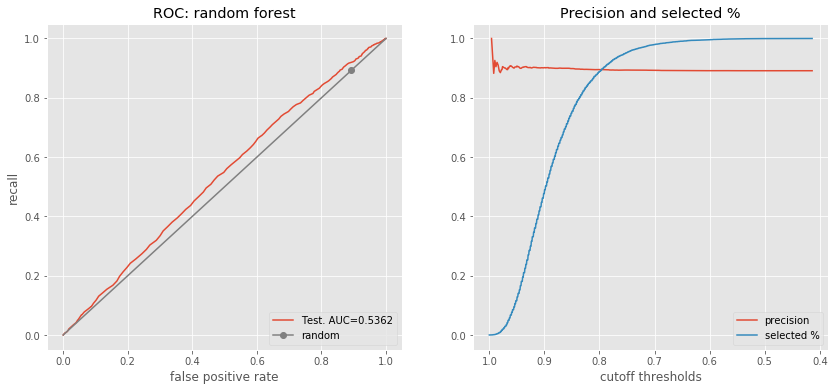

1.00000 0.53625 
{0.05: 0.9079089924160346, 0.1: 0.9041353383458646, 0.2: 0.9038594073053067, 1: 0.8911909591422776}
['B2']


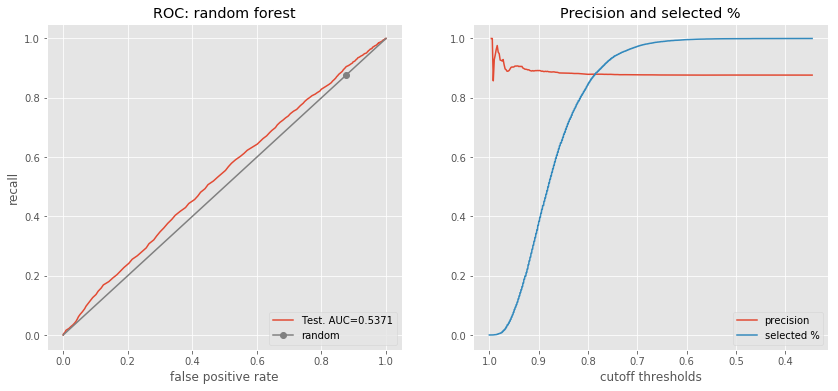

1.00000 0.53715 
{0.05: 0.9025191675794084, 0.1: 0.9072104018912528, 0.2: 0.8956060159245061, 1: 0.8764443277310925}
['B3']


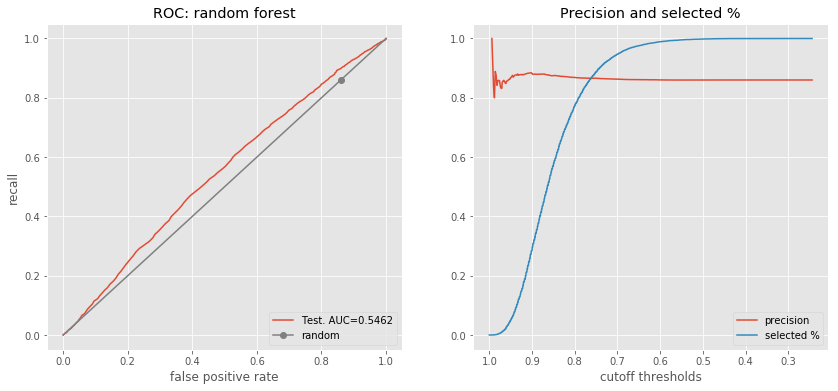

1.00000 0.54621 
{0.05: 0.8694267515923567, 0.1: 0.8764247150569886, 0.2: 0.8819789939192925, 1: 0.8599716242057862}
['B4']


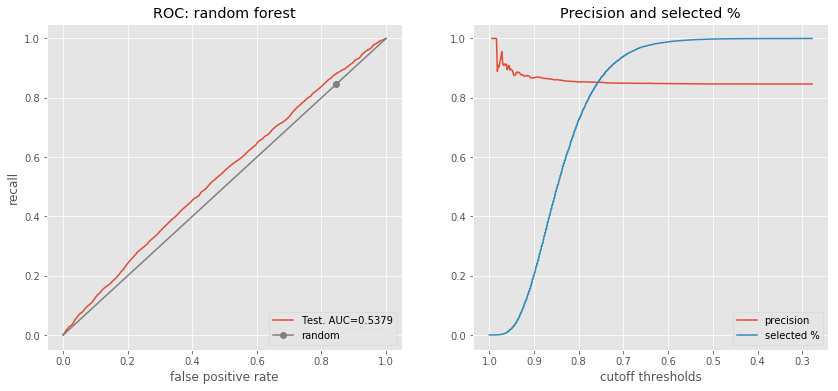

1.00000 0.53786 
{0.05: 0.8857696030977734, 0.1: 0.8729989327641408, 0.2: 0.8677777777777776, 1: 0.846503178928247}
['B5']


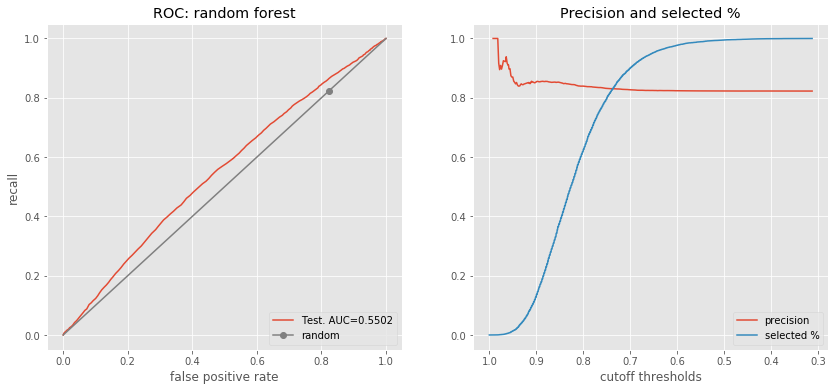

1.00000 0.55023 
{0.05: 0.8465723612622416, 0.1: 0.852664576802508, 0.2: 0.8547054118901627, 1: 0.8226342487318524}
['C1']


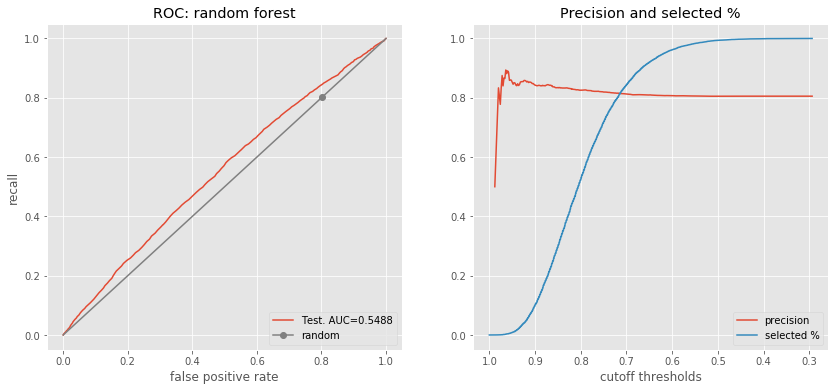

1.00000 0.54881 
{0.05: 0.8552774755168662, 0.1: 0.8416763678696159, 0.2: 0.843026706231454, 1: 0.8052878518894243}
['C2']


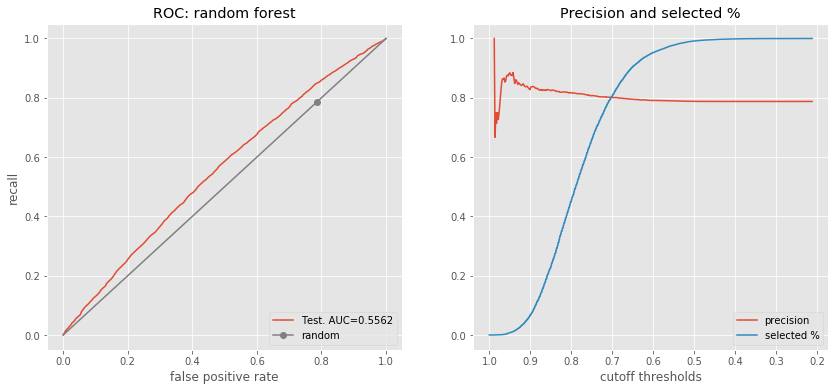

1.00000 0.55622 
{0.05: 0.8388324873096445, 0.1: 0.832282471626734, 0.2: 0.8278688524590164, 1: 0.7875401498929336}
['C3']


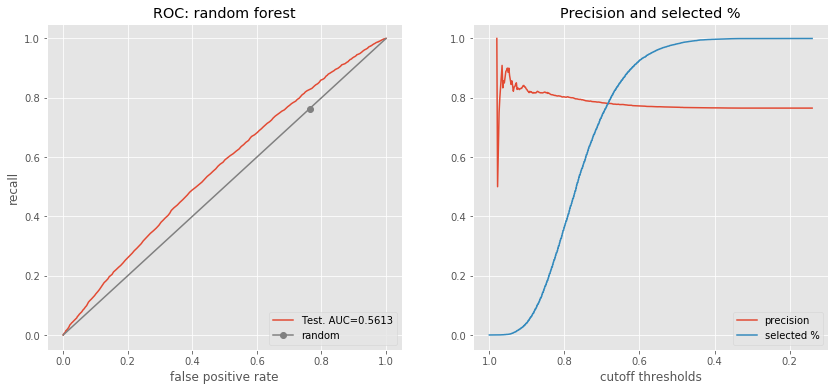

1.00000 0.56132 
{0.05: 0.8173803526448362, 0.1: 0.8206419131529263, 0.2: 0.8126188966391883, 1: 0.7651189745687598}
['C4']


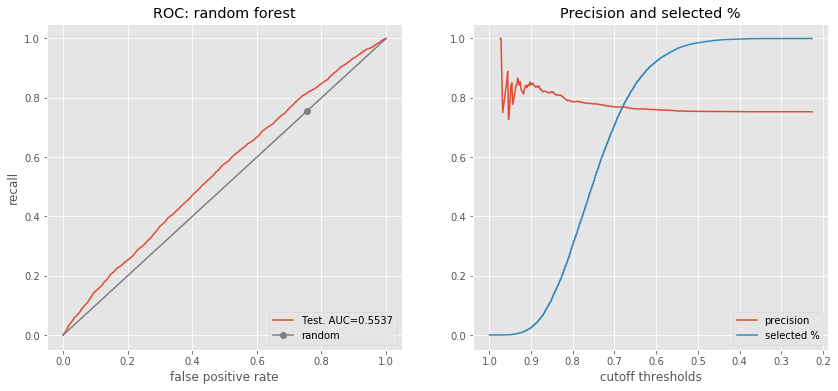

1.00000 0.55367 
{0.05: 0.8408037094281299, 0.1: 0.8165771297006907, 0.2: 0.8051441932969603, 1: 0.7528462998102466}
['C5']


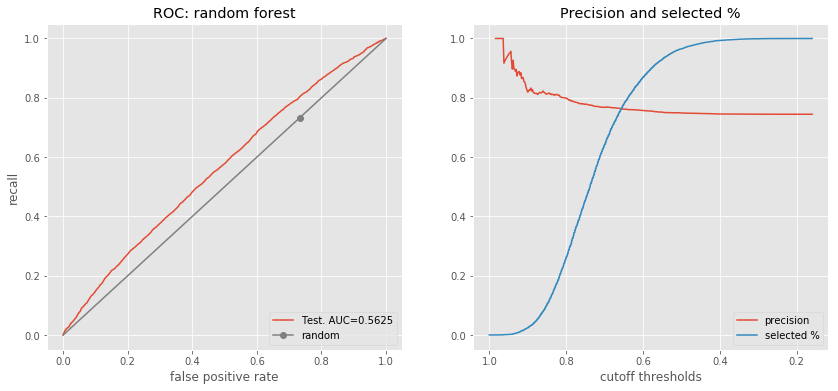

1.00000 0.56250 
{0.05: 0.8114186851211073, 0.1: 0.8129032258064516, 0.2: 0.8027088036117382, 1: 0.7444476772379013}
['D1']


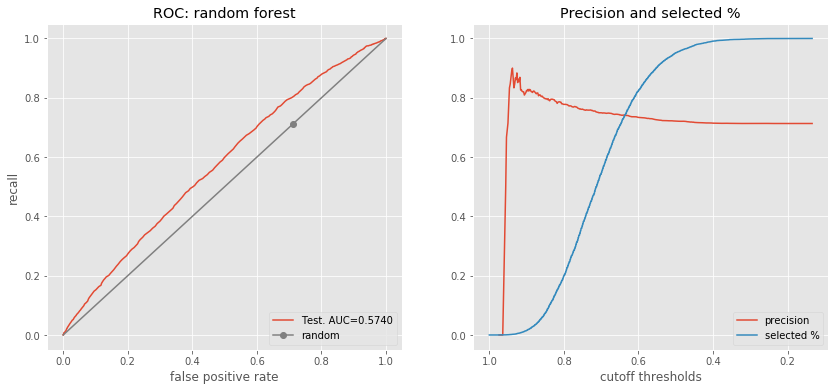

1.00000 0.57399 
{0.05: 0.8058455114822547, 0.1: 0.7940234791889008, 0.2: 0.7777155655095184, 1: 0.7131612455145272}
['D2']


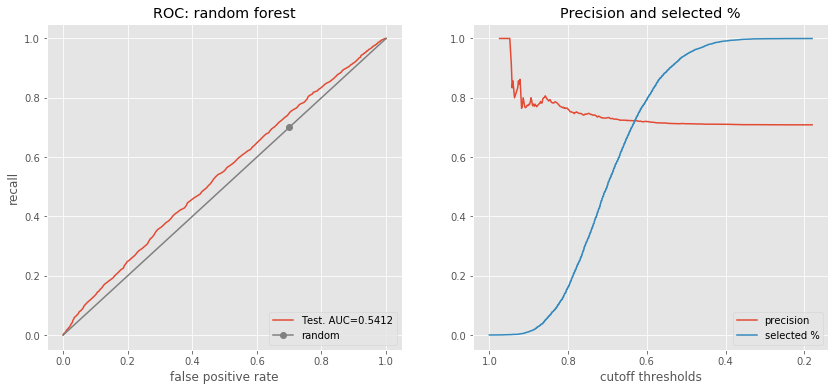

1.00000 0.54123 
{0.05: 0.8020304568527918, 0.1: 0.7795698924731183, 0.2: 0.7496714848883048, 1: 0.7087498288374641}
['D3']


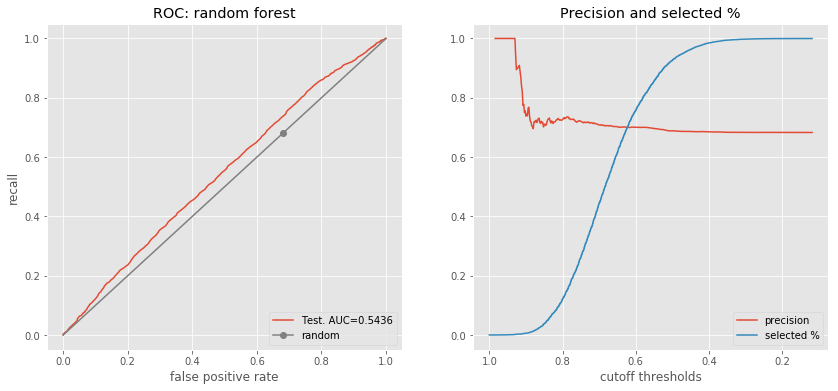

1.00000 0.54364 
{0.05: 0.7289473684210527, 0.1: 0.724517906336088, 0.2: 0.7258848022206801, 1: 0.6829374275782155}
['D4']


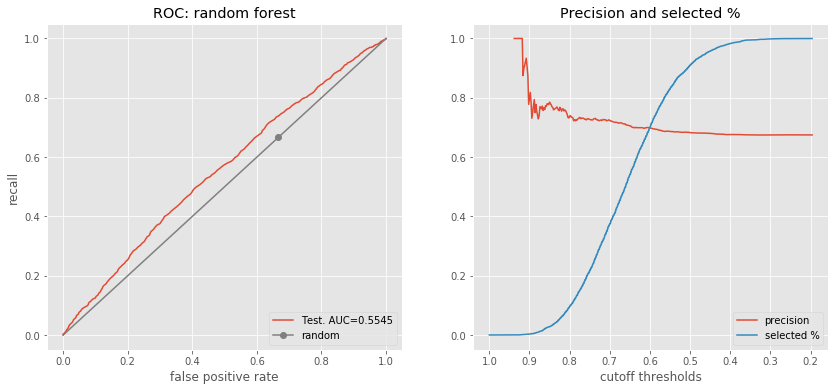

1.00000 0.55448 
{0.05: 0.7564102564102564, 0.1: 0.7345575959933223, 0.2: 0.7296173044925125, 1: 0.67470506592644}
['D5']


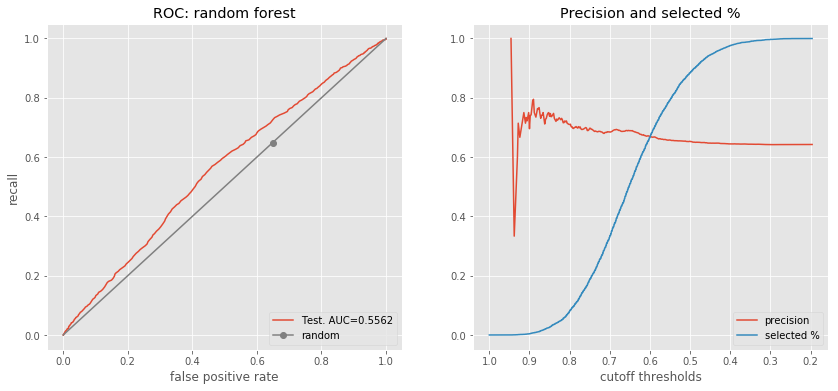

1.00000 0.55616 
{0.05: 0.7256317689530686, 0.1: 0.7007168458781362, 0.2: 0.6910420475319927, 1: 0.6424219345011424}
['E1']


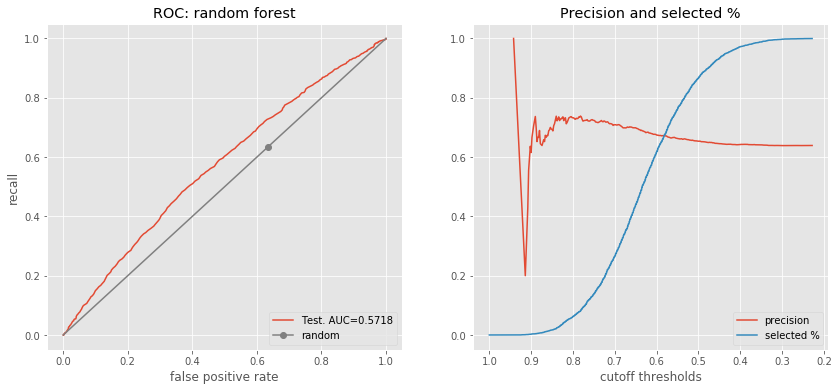

1.00000 0.57180 
{0.05: 0.7236842105263158, 0.1: 0.7238307349665926, 0.2: 0.7178378378378379, 1: 0.6390682656826568}
['E2']


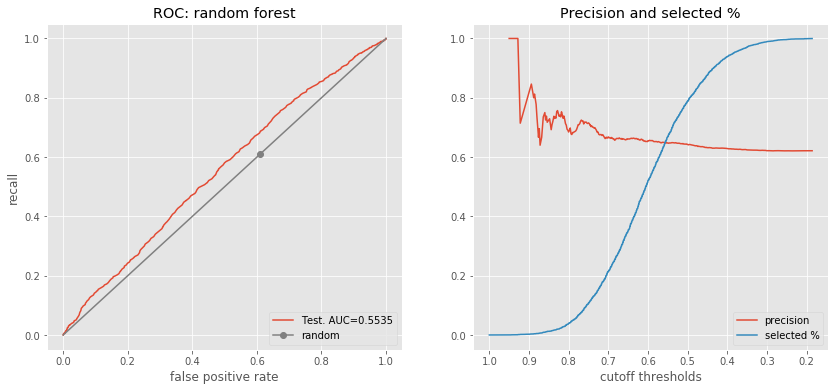

1.00000 0.55350 
{0.05: 0.685, 0.1: 0.7131782945736436, 0.2: 0.6653279785809907, 1: 0.6213383499059393}
['E3']


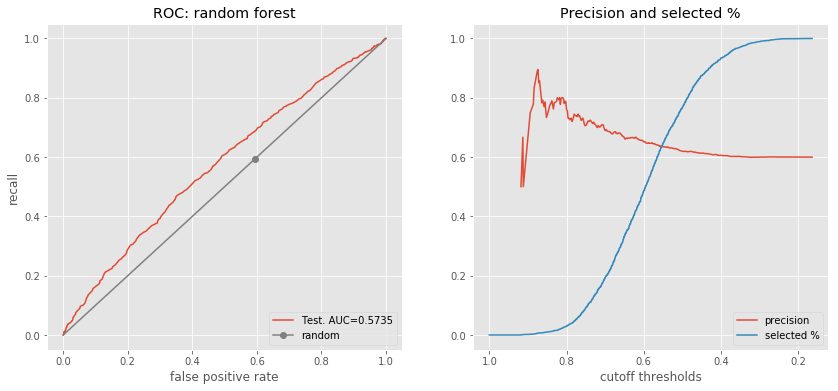

1.00000 0.57353 
{0.05: 0.738095238095238, 0.1: 0.7195121951219512, 0.2: 0.6868044515103339, 1: 0.5996061700032819}
['E4']


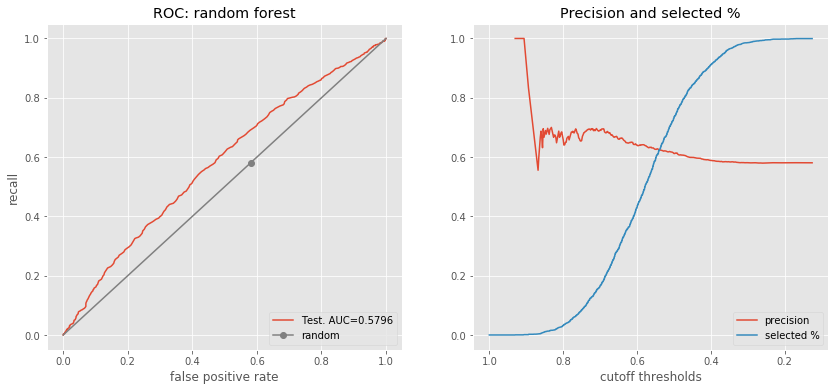

1.00000 0.57958 
{0.05: 0.6842105263157895, 0.1: 0.6900369003690037, 0.2: 0.6814671814671815, 1: 0.5806836248012719}
['E5']


In [233]:
# Looping through the function for each sub_grade:
predictions = pd.DataFrame(columns=['good','p'])
model_name = 'random forest'
df_report = df_template.copy()

# for term in (0,1):
for sub_grade in range(1,35):

    X_train_s = X_train[X_train.sub_grade==sub_grade]
    X_test_s = X_test[X_test.sub_grade==sub_grade]
    y_train_s = y_train[X_train.sub_grade==sub_grade]
    y_test_s = y_test[X_test.sub_grade==sub_grade]

    y_test_s, y_test_hat_s, AUC_train, AUC_test, precision =\
        predict_probs(X_train_s, X_test_s, y_train_s, y_test_s,
                    model_name, 
                    show_plot=False)

    y_test_hat_s = pd.Series(np.squeeze(y_test_hat_s), name='p', index=y_test_s.index)
    grade_predictions = pd.concat([y_test_s, y_test_hat_s], axis=1)
    predictions = pd.concat([predictions, grade_predictions], axis=0)

    df_report.loc[df_report.shape[0]] = ([model_name] +
                                         [sub_grades_dict_reverse[sub_grade]] +
                                         [f'{len(y_test_s):,}'] +
                                         [np.round(AUC_test, 4)] +
                                         [np.round(x,4) for x in precision.values()] + 
                            [np.round(x/precision[1],4) for x in list(precision.values())[:-1]] 
                                        )
    print(f'{[sub_grades_dict_reverse[sub_grade]]}') 


In [234]:
y_test_hat_s.head()

463090    0.580
636059    0.822
376500    0.508
832185    0.718
812072    0.578
Name: p, dtype: float64

In [235]:
predictions.head()

,good,p
51282,1,0.996
1031848,1,0.986
76075,1,0.986
84185,1,0.928
441736,1,0.992


In [236]:
df_report

,model,run,n_loans,AUC_test,prec_5,prec_10,prec_20,support,improvement_ratio_5,improvement_ratio_10,improvement_ratio_20
0,random forest,A1,"9,162",0.5666,0.9736,0.9736,0.9775,0.9681,1.0056,1.0056,1.0097
1,random forest,A2,"6,824",0.5568,0.9603,0.9588,0.9614,0.9499,1.0110,1.0094,1.0121
2,random forest,A3,"6,570",0.5740,0.9578,0.9637,0.9603,0.9495,1.0088,1.0150,1.0114
3,random forest,A4,"9,587",0.5366,0.9482,0.9485,0.9467,0.9346,1.0146,1.0149,1.0130
4,random forest,A5,"12,338",0.5228,0.9468,0.9295,0.9258,0.9194,1.0298,1.0110,1.0070
5,random forest,B1,"13,509",0.5508,0.9361,0.9274,0.9221,0.9027,1.0371,1.0274,1.0215
6,random forest,B2,"13,804",0.5362,0.9079,0.9041,0.9039,0.8912,1.0188,1.0145,1.0142
7,random forest,B3,"15,232",0.5371,0.9025,0.9072,0.8956,0.8764,1.0298,1.0351,1.0219
8,random forest,B4,"16,211",0.5462,0.8694,0.8764,0.8820,0.8600,1.0110,1.0191,1.0256
9,random forest,B5,"16,515",0.5379,0.8858,0.8730,0.8678,0.8465,1.0464,1.0313,1.0251


## LOGISTIC REGRESSION

In [34]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_



In [35]:
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)


[(0.15376686766441264, 'annual_inc'),
 (0.12759853158655304, 'credit_hist'),
 (0.1114867725998841, 'int_rate'),
 (0.10506816854723863, 'funded_amnt'),
 (0.10493704678215689, 'loan_amnt'),
 (0.07685537740173716, 'emp_length_num'),
 (0.06121291738723458, 'sub_grade'),
 (0.05918120661965496, 'fico_range_low'),
 (0.05897496518582801, 'fico_range_high'),
 (0.03119397280263834, 'verification_status'),
 (0.023352487054592273, 'grade'),
 (0.013441675286162582, 'term'),
 (0.013384195524634913, 'purpose_debt_consolidation'),
 (0.010740987516150102, 'purpose_credit_card'),
 (0.0061326307365620345, 'purpose_home_improvement'),
 (0.005838384840933274, 'purpose_other'),
 (0.005741683162907891, 'home_ownership_RENT'),
 (0.005473105313240043, 'home_ownership_MORTGAGE'),
 (0.005121983677283637, 'home_ownership_OWN'),
 (0.0036531663408770603, 'purpose_major_purchase'),
 (0.002769823493633678, 'has_desc'),
 (0.002551694709738912, 'purpose_small_business'),
 (0.0025308066921121424, 'purpose_medical'),
 (0

## DECISION TREE

In [36]:
# Creating the decision tree classifier instance
dt_model = tree.DecisionTreeClassifier()

# Fitting the model
dt_model = dt_model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
dt_predictions = dt_model.predict(X_test_scaled)



In [37]:
# Calculating the confusion matrix
dt_cm = confusion_matrix(y_test, dt_predictions)
dt_cm_df = pd.DataFrame(
    dt_cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
dt_acc_score = accuracy_score(y_test, dt_predictions)



In [38]:
# Displaying results
print("Confusion Matrix")
display(dt_cm_df)
print(f"Accuracy Score : {dt_acc_score}")
print("Classification Report")
print(classification_report(y_test, dt_predictions))


Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,14170,35730
Actual 1,41562,168726


Accuracy Score : 0.7029378756898857
Classification Report
              precision    recall  f1-score   support

           0       0.25      0.28      0.27     49900
           1       0.83      0.80      0.81    210288

    accuracy                           0.70    260188
   macro avg       0.54      0.54      0.54    260188
weighted avg       0.72      0.70      0.71    260188



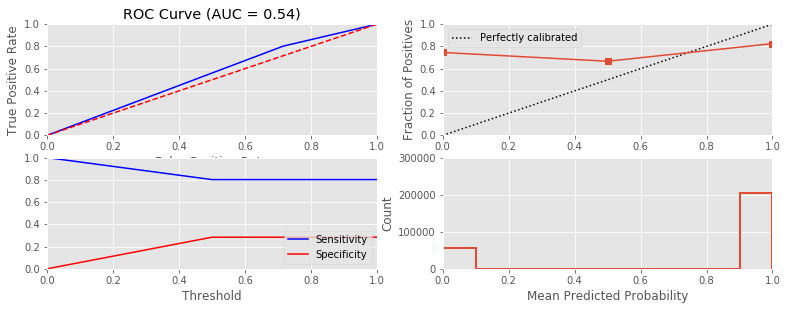

In [84]:
# get roc/auc info
Y_score = dt_model.predict_proba(X_test_scaled)[:,1]
fpr = dict()
tpr = dict()
thresholds = dict()
#fpr, tpr, _ = roc_curve(y_test, Y_score)
fpr, tpr, thresholds = roc_curve(y_test, Y_score)

roc_auc = dict()
roc_auc = auc(fpr, tpr)

# make the plot
# plt.figure(figsize=(10,10))
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim([-0.05, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.grid(True)
# plt.plot(fpr, tpr, label='AUC = {0}'.format(roc_auc))        
# plt.legend(loc="lower right", shadow=True, fancybox =True) 



plt.figure(figsize = (13, 4.5))
plt.subplot(2, 2, 1)

plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, Y_score))
plt.plot(fpr, tpr, 'b')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1]); plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.subplot(2, 2, 3)

plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
plt.legend(loc = 'lower right')
plt.xlim([0,1]); plt.ylim([0,1])
plt.xlabel('Threshold')

plt.subplot(2, 2, 2)

fp_0, mpv_0 = calibration_curve(y_test, Y_score, n_bins = 10)
plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
plt.plot(mpv_0, fp_0, 's-')
plt.ylabel('Fraction of Positives')
plt.xlim([0,1]); plt.ylim([0,1])
plt.legend(loc ='upper left')

plt.subplot(2, 2, 4)
plt.hist(Y_score, range=(0, 1), bins=10, histtype="step", lw=2)
plt.xlim([0,1]); plt.ylim([0,300000])
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Count')

plt.show()

In [ ]:
# # Create DOT data
# dot_data = tree.export_graphviz(
#     dt_model, out_file=None, feature_names=X.columns, class_names=["0", "1"], filled=True
# )

# # Draw graph
# graph = pydotplus.graph_from_dot_data(dot_data)

# # Show graph
# Image(graph.create_png())

## LOGISTIC REGRESSION

In [50]:
lr_classifier = LogisticRegression(solver='lbfgs', random_state=34)
lr_classifier

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=34, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [51]:
# Train the data
lr_classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=34, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [52]:
# Score the model
print(f"Training Data Score: {lr_classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {lr_classifier.score(X_test, y_test)}")

Training Data Score: 0.8077531118524554
Testing Data Score: 0.80821559795225


In [53]:
lr_predictions = lr_classifier.predict(X_test)

In [54]:
#Create Confusion Matrix
lr_cm= confusion_matrix(y_test, lr_predictions)
lr_cm_df = pd.DataFrame(
    lr_cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

In [55]:
# Calculating the accuracy score
lr_acc_score = accuracy_score(y_test, lr_predictions)


In [56]:
# Displaying results
print("Confusion Matrix")
display(lr_cm_df)
print(f"Accuracy Score : {lr_acc_score}")
print("Classification Report")
print(classification_report(y_test, lr_predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,0,49900
Actual 1,0,210288


Accuracy Score : 0.80821559795225
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     49900
           1       0.81      1.00      0.89    210288

    accuracy                           0.81    260188
   macro avg       0.40      0.50      0.45    260188
weighted avg       0.65      0.81      0.72    260188



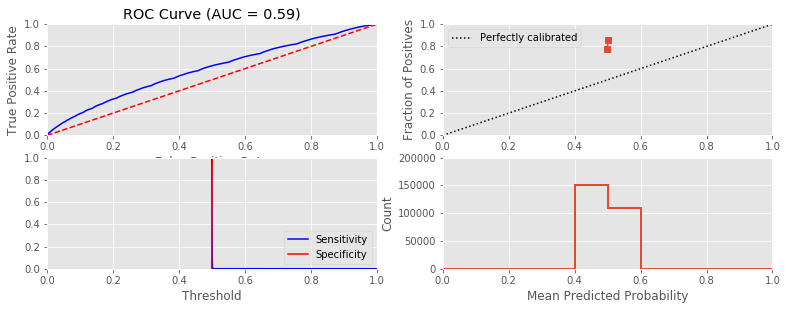

In [87]:
# get roc/auc info
Y_score = lr_classifier.predict_proba(X_test_scaled)[:,1]
fpr = dict()
tpr = dict()
thresholds = dict()
#fpr, tpr, _ = roc_curve(y_test, Y_score)
fpr, tpr, thresholds = roc_curve(y_test, Y_score)

roc_auc = dict()
roc_auc = auc(fpr, tpr)

# make the plot
# plt.figure(figsize=(10,10))
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim([-0.05, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.grid(True)
# plt.plot(fpr, tpr, label='AUC = {0}'.format(roc_auc))        
# plt.legend(loc="lower right", shadow=True, fancybox =True) 



plt.figure(figsize = (13, 4.5))
plt.subplot(2, 2, 1)

plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, Y_score))
plt.plot(fpr, tpr, 'b')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1]); plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.subplot(2, 2, 3)

plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
plt.legend(loc = 'lower right')
plt.xlim([0,1]); plt.ylim([0,1])
plt.xlabel('Threshold')

plt.subplot(2, 2, 2)

fp_0, mpv_0 = calibration_curve(y_test, Y_score, n_bins = 10)
plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
plt.plot(mpv_0, fp_0, 's-')
plt.ylabel('Fraction of Positives')
plt.xlim([0,1]); plt.ylim([0,1])
plt.legend(loc ='upper left')

plt.subplot(2, 2, 4)
plt.hist(Y_score, range=(0, 1), bins=10, histtype="step", lw=2)
plt.xlim([0,1]); plt.ylim([0,200000])
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Count')

plt.show()

In [58]:
# Predict outcomes for test data set
#pd.DataFrame({"Prediction": lr_predictions, "Actual": y_test})

In [59]:
from sklearn.metrics import precision_recall_curve


probs_lr = lr_classifier.predict_proba(X_test)[:, 1]
probs_rf = rf_model.predict_proba(X_test)[:, 1]
#probs_dt = dt_model.predict_proba(X_test)[:, 1]
precision_lr, recall_lr, _ = precision_recall_curve(y_test, probs_lr, pos_label=1)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, probs_rf, pos_label=1)
#precision_dt, recall_dt, _ = precision_recall_curve(y_test, probs_dt, pos_label=1)

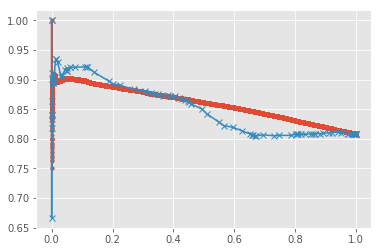

In [60]:
plt.plot(recall_lr, precision_lr, marker='.')
plt.plot(recall_rf, precision_rf, marker='x')
#plt.plot(recall_dt, precision_rf, marker='v')

## Gradient Boosted Tree

In [61]:
# Create a classifier object
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gbt_classifier = GradientBoostingClassifier(n_estimators=20,
                                            learning_rate=learning_rate,
                                            max_features=5,
                                            max_depth=3,
                                            random_state=32)

    # Fit the model
    gbt_classifier.fit(X_train_scaled, y_train.ravel())
    print("Learning rate: ", learning_rate)

    # Score the model
    print("Accuracy score (training): {0:.3f}".format(
        gbt_classifier.score(
            X_train_scaled,
            y_train.ravel())))
    print("Accuracy score (validation): {0:.3f}".format(
        gbt_classifier.score(
            X_test_scaled,
            y_test.ravel())))
    print()

Learning rate:  0.05
Accuracy score (training): 0.808
Accuracy score (validation): 0.808

Learning rate:  0.1
Accuracy score (training): 0.808
Accuracy score (validation): 0.808

Learning rate:  0.25
Accuracy score (training): 0.809
Accuracy score (validation): 0.810

Learning rate:  0.5
Accuracy score (training): 0.809
Accuracy score (validation): 0.809

Learning rate:  0.75
Accuracy score (training): 0.809
Accuracy score (validation): 0.809

Learning rate:  1
Accuracy score (training): 0.809
Accuracy score (validation): 0.810



In [62]:
# Choose a learning rate and create classifier
gbt_classifier = GradientBoostingClassifier(n_estimators=20,
                                        learning_rate=0.75,
                                        max_features=5,
                                        max_depth=3,
                                        random_state=32)

# Fit the model
gbt_classifier.fit(X_train_scaled, y_train.ravel())

# Make Prediction
gbt_predictions = gbt_classifier.predict(X_test_scaled)
pd.DataFrame({"Prediction": gbt_predictions, "Actual": y_test.ravel()}).head(20)


,Prediction,Actual
0,1,1
1,1,1
2,1,1
3,1,0
4,1,1
5,1,1
6,1,1
7,1,1
8,1,0
9,1,1


In [63]:
#create Confusion Matrix
gbt_cm= confusion_matrix(y_test, gbt_predictions)
gbt_cm_df = pd.DataFrame(
    gbt_cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
gbt_acc_score = accuracy_score(y_test, gbt_predictions)


In [64]:
# Displaying results
print("Confusion Matrix")
display(gbt_cm_df)
print(f"Accuracy Score : {gbt_acc_score}")
print("Classification Report")
print(classification_report(y_test, gbt_predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,2419,47481
Actual 1,2125,208163


Accuracy Score : 0.8093455501406676
Classification Report
              precision    recall  f1-score   support

           0       0.53      0.05      0.09     49900
           1       0.81      0.99      0.89    210288

    accuracy                           0.81    260188
   macro avg       0.67      0.52      0.49    260188
weighted avg       0.76      0.81      0.74    260188



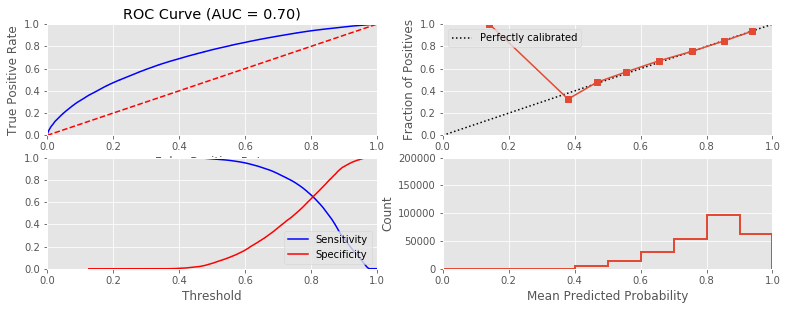

In [88]:
# get roc/auc info
Y_score = gbt_classifier.predict_proba(X_test_scaled)[:,1]
fpr = dict()
tpr = dict()
thresholds = dict()
#fpr, tpr, _ = roc_curve(y_test, Y_score)
fpr, tpr, thresholds = roc_curve(y_test, Y_score)

roc_auc = dict()
roc_auc = auc(fpr, tpr)

# make the plot
# plt.figure(figsize=(10,10))
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim([-0.05, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.grid(True)
# plt.plot(fpr, tpr, label='AUC = {0}'.format(roc_auc))        
# plt.legend(loc="lower right", shadow=True, fancybox =True) 



plt.figure(figsize = (13, 4.5))
plt.subplot(2, 2, 1)

plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, Y_score))
plt.plot(fpr, tpr, 'b')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1]); plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.subplot(2, 2, 3)

plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
plt.legend(loc = 'lower right')
plt.xlim([0,1]); plt.ylim([0,1])
plt.xlabel('Threshold')

plt.subplot(2, 2, 2)

fp_0, mpv_0 = calibration_curve(y_test, Y_score, n_bins = 10)
plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
plt.plot(mpv_0, fp_0, 's-')
plt.ylabel('Fraction of Positives')
plt.xlim([0,1]); plt.ylim([0,1])
plt.legend(loc ='upper left')

plt.subplot(2, 2, 4)
plt.hist(Y_score, range=(0, 1), bins=10, histtype="step", lw=2)
plt.xlim([0,1]); plt.ylim([0,200000])
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Count')

plt.show()

## Neural Network

In [90]:
# Creating training, validation, and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=78)

In [91]:
# Model set-up
number_input_features = (X_train.shape[-1])
hidden_nodes_layer1 = 50
hidden_nodes_layer2 = 50


In [92]:
# Define the LSTM RNN model
nn_model = Sequential()

# Layer 1
nn_model.add(
    Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Layer 2
nn_model.add(Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn_model.add(Dense(1, activation="sigmoid"))

In [93]:
# Compile the model
nn_model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[
        "accuracy",
        tf.keras.metrics.TruePositives(name="tp"),
        tf.keras.metrics.TrueNegatives(name="tn"),
        tf.keras.metrics.FalsePositives(name="fp"),
        tf.keras.metrics.FalseNegatives(name="fn"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
    ],
)

In [94]:
# Summarize the model
nn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 50)                1650      
_________________________________________________________________
dense_4 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 4,251
Trainable params: 4,251
Non-trainable params: 0
_________________________________________________________________


In [95]:
# Training the model
batch_size = 1000
epochs = 50
training_history = nn_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
)

Epoch 1/50
586/586 [==============================] - 2s 3ms/step - loss: 45.8827 - accuracy: 0.6959 - tp: 384423.0000 - tn: 22963.0000 - fp: 89641.0000 - fn: 88396.0000 - precision: 0.8109 - recall: 0.8130 - auc: 0.5095 - val_loss: 6.3833 - val_accuracy: 0.8071 - val_tp: 157466.0000 - val_tn: 42.0000 - val_fp: 37415.0000 - val_fn: 218.0000 - val_precision: 0.8080 - val_recall: 0.9986 - val_auc: 0.5065
Epoch 2/50
586/586 [==============================] - 1s 3ms/step - loss: 19.5559 - accuracy: 0.6960 - tp: 384310.0000 - tn: 23141.0000 - fp: 89463.0000 - fn: 88509.0000 - precision: 0.8112 - recall: 0.8128 - auc: 0.5105 - val_loss: 4.5848 - val_accuracy: 0.6663 - val_tp: 114112.0000 - val_tn: 15919.0000 - val_fp: 21538.0000 - val_fn: 43572.0000 - val_precision: 0.8412 - val_recall: 0.7237 - val_auc: 0.5919
Epoch 3/50
586/586 [==============================] - 2s 3ms/step - loss: 18.2729 - accuracy: 0.6972 - tp: 384220.0000 - tn: 23965.0000 - fp: 88639.0000 - fn: 88599.0000 - precision: 

In [96]:
# Evaluate the model
scores = nn_model.evaluate(X_test, y_test, verbose=0)

# Define metrics dictionary
nn_metrics = {k: v for k, v in zip(nn_model.metrics_names, scores)}

# Display evaluation metrics results
display(nn_metrics)

{'loss': 0.4707828462123871,
 'accuracy': 0.8080810904502869,
 'tp': 206499.0,
 'tn': 3754.0,
 'fp': 46146.0,
 'fn': 3789.0,
 'precision': 0.8173484802246094,
 'recall': 0.9819818735122681,
 'auc': 0.6762810349464417}

In [97]:

# Define the confusion matrix data
nn_cm_df = pd.DataFrame(
    {
        "Positive (1)": [f"TP={nn_metrics['tp']}", f"FP={nn_metrics['fn']}"],
        "Negative (0)": [f"FN={nn_metrics['fp']}", f"TN={nn_metrics['tn']}"],
    },
    index=["Positive(1)", "Negative(0)"],
)
nn_cm_df.index.name = "Actual"
nn_cm_df.columns.name = "Predicted"

# Show the confusion matrix
nn_cm_df

Predicted,Positive (1),Negative (0)
Actual,,
Positive(1),TP=206499.0,FN=46146.0
Negative(0),FP=3789.0,TN=3754.0


In [98]:
# Predict classes using testing data
y_predict_classes = nn_model.predict_classes(X_test, batch_size=1000)

# Display classification report
print(classification_report(y_predict_classes, y_test))

              precision    recall  f1-score   support

           0       0.08      0.50      0.13      7543
           1       0.98      0.82      0.89    252645

    accuracy                           0.81    260188
   macro avg       0.53      0.66      0.51    260188
weighted avg       0.96      0.81      0.87    260188



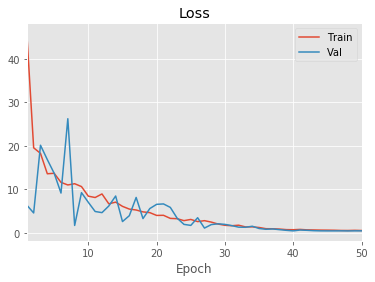

In [99]:
# Plotting loss
loss_df = pd.DataFrame(
    {
        "Epoch": range(1, epochs + 1),
        "Train": training_history.history["loss"],
        "Val": training_history.history["val_loss"],
    }
)
loss_df.set_index("Epoch", inplace=True)
loss_df.plot(title="Loss")

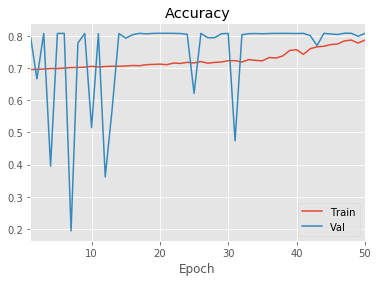

In [100]:
# Plotting accuracy
accuracy_df = pd.DataFrame(
    {
        "Epoch": range(1, epochs + 1),
        "Train": training_history.history["accuracy"],
        "Val": training_history.history["val_accuracy"],
    }
)
accuracy_df.set_index("Epoch", inplace=True)
accuracy_df.plot(title="Accuracy")

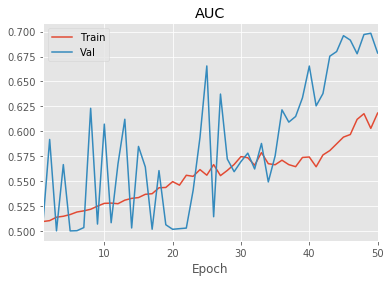

In [101]:
# Plotting AUC
auc_df = pd.DataFrame(
    {
        "Epoch": range(1, epochs + 1),
        "Train": training_history.history["auc"],
        "Val": training_history.history["val_auc"],
    }
)
auc_df.set_index("Epoch", inplace=True)
auc_df.plot(title="AUC")

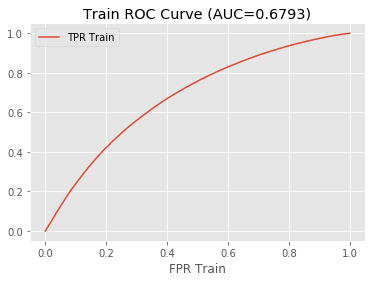

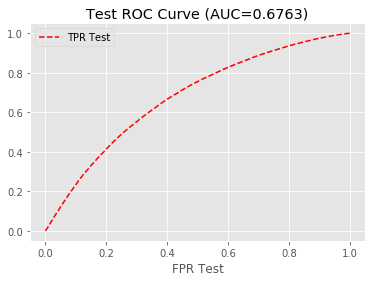

In [102]:
# Making predictions to feed the roc_curve module
train_predictions = nn_model.predict(X_train, batch_size=1000)
test_predictions = nn_model.predict(X_test, batch_size=1000)

# Calculate the ROC curve and AUC for the training set
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, train_predictions)
auc_train = auc(fpr_train, tpr_train)
auc_train = round(auc_train, 4)

# Calculate the ROC curve and AUC for the testing set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, test_predictions)
auc_test = auc(fpr_test, tpr_test)
auc_test = round(auc_test, 4)

# Create a DataFrame with the fpr and tpr results
roc_df_train = pd.DataFrame({"FPR Train": fpr_train, "TPR Train": tpr_train,})
roc_df_test = pd.DataFrame({"FPR Test": fpr_test, "TPR Test": tpr_test,})

# Plotting the ROC Curves
roc_df_train.plot(
    x="FPR Train",
    y="TPR Train",
    xlim=([-0.05, 1.05]),
    title=f"Train ROC Curve (AUC={auc_train})",
)

roc_df_test.plot(
    x="FPR Test",
    y="TPR Test",
    color="red",
    style="--",
    xlim=([-0.05, 1.05]),
    title=f"Test ROC Curve (AUC={auc_test})",
)

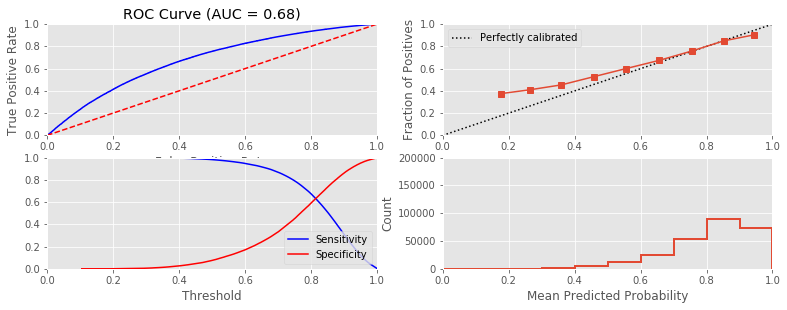

In [103]:
Y_score = nn_model.predict(X_test, batch_size=1000)
fpr = dict()
tpr = dict()
thresholds = dict()
fpr, tpr, thresholds = roc_curve(y_test, Y_score)

roc_auc = dict()
roc_auc = auc(fpr, tpr)

# make the plot
# plt.figure(figsize=(10,10))
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim([-0.05, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.grid(True)
# plt.plot(fpr, tpr, label='AUC = {0}'.format(roc_auc))        
# plt.legend(loc="lower right", shadow=True, fancybox =True) 



plt.figure(figsize = (13, 4.5))
plt.subplot(2, 2, 1)

plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, Y_score))
plt.plot(fpr, tpr, 'b')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1]); plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.subplot(2, 2, 3)

plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
plt.legend(loc = 'lower right')
plt.xlim([0,1]); plt.ylim([0,1])
plt.xlabel('Threshold')

plt.subplot(2, 2, 2)

fp_0, mpv_0 = calibration_curve(y_test, Y_score, n_bins = 10)
plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
plt.plot(mpv_0, fp_0, 's-')
plt.ylabel('Fraction of Positives')
plt.xlim([0,1]); plt.ylim([0,1])
plt.legend(loc ='upper left')

plt.subplot(2, 2, 4)
plt.hist(Y_score, range=(0, 1), bins=10, histtype="step", lw=2)
plt.xlim([0,1]); plt.ylim([0,200000])
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Count')

plt.show()